In [1]:
import pandas, os, re, sys, importlib, random, functools
import numpy as np

import orthoListHelper
import pum2Helper
import fbfTargetHelper
import human_gene_ensmbl_map
import language
import configuration
import write_excel

import simple.targets
import fbfTargetSet
import complexTargetSet
importlib.reload(configuration)



"""
List maker should take:
Excel1, Excel2
Language1/2, Species1/2 declarations
How to look things up in the excel files.

From the above, we get:
List1 Language1 Species1
List2 Language2 Species2

The above might be output in a new excel file with sheets for each input.

At this point, the comparison maker takes the input two lists, language/species 
data, and a translater to either List1 in Language2/Species2 equivalents,
or visa versa. To do the translations, some path needs to be outlined for each
step of translation. For example:

List1(Language1/Species1) -> List1(Language3/Species1) -> List1(Language2/Species2)

"""



'\nList maker should take:\nExcel1, Excel2\nLanguage1/2, Species1/2 declarations\nHow to look things up in the excel files.\n\nFrom the above, we get:\nList1 Language1 Species1\nList2 Language2 Species2\n\nThe above might be output in a new excel file with sheets for each input.\n\nAt this point, the comparison maker takes the input two lists, language/species \ndata, and a translater to either List1 in Language2/Species2 equivalents,\nor visa versa. To do the translations, some path needs to be outlined for each\nstep of translation. For example:\n\nList1(Language1/Species1) -> List1(Language3/Species1) -> List1(Language2/Species2)\n\n'

In [2]:

importlib.reload(configuration)

config_text = """
ortholist=lib/OrthoList_20130531.csv

#-----------
test1=[<
    filename=/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/tables/test1.txt
    language=gene_name
    species=worm
    read_csv=True
    read_every_line_as_gene=True
    lowercase=True
    >]

test2=[<
    filename=/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/tables/test2.txt
    language=Gene symbol
    species=human
    read_csv=True
    read_every_line_as_gene=True
    capitalize=True
    >]
#-----------
FbfOO25C=[<
    filename=/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/tables/Table S1 Peaks.xls
    language=gene_name
    species=worm
    load_sheets_of_excel=True
    sheetnames=OO FBF (25°C)#('OO FBF (25°C)', 'SP FBF (25°C)', 'OO FBF-1 (20°C)', 'OO FBF-2 (20°C)')
    column_name=Gene name
    >]

Top500FbfOO25C=[<
    filename=/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/tables/Table S1 Peaks.xls
    language=gene_name
    species=worm
    load_sheets_of_excel=True
    sheetnames=OO FBF (25°C)#('OO FBF (25°C)', 'SP FBF (25°C)', 'OO FBF-1 (20°C)', 'OO FBF-2 (20°C)')
    column_name=Gene name
    subset=True
    subset_function=lambda x: x['Rank']<501
    >]

FbfSP25C=[<
    filename=/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/tables/Table S1 Peaks.xls
    language=gene_name
    species=worm
    load_sheets_of_excel=True
    sheetnames=SP FBF (25°C)#('OO FBF (25°C)', 'SP FBF (25°C)', 'OO FBF-1 (20°C)', 'OO FBF-2 (20°C)')
    column_name=Gene name
    >]

Top500FbfSP25C=[<
    filename=/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/tables/Table S1 Peaks.xls
    language=gene_name
    species=worm
    load_sheets_of_excel=True
    sheetnames=SP FBF (25°C)#('OO FBF (25°C)', 'SP FBF (25°C)', 'OO FBF-1 (20°C)', 'OO FBF-2 (20°C)')
    column_name=Gene name
    subset=True
    subset_function=lambda x: x['Rank']<501
    >]
    
Fbf1_20C=[<
    filename=/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/tables/Table S1 Peaks.xls
    language=gene_name
    species=worm
    load_sheets_of_excel=True
    sheetnames=OO FBF-1 (20°C)#('OO FBF (25°C)', 'SP FBF (25°C)', 'OO FBF-1 (20°C)', 'OO FBF-2 (20°C)')
    column_name=Gene name
    >]

Top500Fbf1_20C=[<
    filename=/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/tables/Table S1 Peaks.xls
    language=gene_name
    species=worm
    load_sheets_of_excel=True
    sheetnames=OO FBF-1 (20°C)#('OO FBF (25°C)', 'SP FBF (25°C)', 'OO FBF-1 (20°C)', 'OO FBF-2 (20°C)')
    column_name=Gene name
    subset=True
    subset_function=lambda x: x['Rank']<501
    >]

Fbf2_20C=[<
    filename=/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/tables/Table S1 Peaks.xls
    language=gene_name
    species=worm
    load_sheets_of_excel=True
    sheetnames=OO FBF-2 (20°C)#('OO FBF (25°C)', 'SP FBF (25°C)', 'OO FBF-1 (20°C)', 'OO FBF-2 (20°C)')
    column_name=Gene name
    >]

Top500Fbf2_20C=[<
    filename=/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/tables/Table S1 Peaks.xls
    language=gene_name
    species=worm
    load_sheets_of_excel=True
    sheetnames=OO FBF-2 (20°C)#('OO FBF (25°C)', 'SP FBF (25°C)', 'OO FBF-1 (20°C)', 'OO FBF-2 (20°C)')
    column_name=Gene name
    subset=True
    subset_function=lambda x: x['Rank']<501
    >]
    
BlockI=[<
    filename=/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/tables/Table S6 Blocks.xls
    language=gene_name
    species=worm
    load_sheets_of_excel=True
    sheetnames=Block I
    column_name=Gene name
    >]
    
BlockII=[<
    filename=/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/tables/Table S6 Blocks.xls
    language=gene_name
    species=worm
    load_sheets_of_excel=True
    sheetnames=Block II
    column_name=Gene name
    >]
    
BlockIII=[<
    filename=/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/tables/Table S6 Blocks.xls
    language=gene_name
    species=worm
    load_sheets_of_excel=True
    sheetnames=Block III
    column_name=Gene name
    >]
#-----------
Hafner=[<
    filename=pum2_targets.txt
    language=Gene symbol
    species=human
    read_csv=True
    read_every_line_as_gene=True
    >]

#-----------

Lin_pum1=[<
    filename=/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/orthos/lib/supp_gad.298752.117_SUPPLEMENTAL_Table2sites.xlsx
    load_sheets_of_excel=True
    language=Gene symbol
    species=human
    sheetnames=WT Pum1
    column_name=overlap gene symbol
    capitalize=True
    >]

Lin_pum2=[<
    filename=/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/orthos/lib/supp_gad.298752.117_SUPPLEMENTAL_Table2sites.xlsx
    load_sheets_of_excel=True
    language=Gene symbol
    species=human
    sheetnames=WT Pum2
    column_name=overlap gene symbol
    capitalize=True
    >]
    
Lin_pum=[<
    filename=/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/orthos/lib/supp_gad.298752.117_SUPPLEMENTAL_Table2sites.xlsx
    load_sheets_of_excel=True
    language=Gene symbol
    species=human
    sheetnames=Pum1 or Pum2
    column_name=overlap gene symbol
    capitalize=True
    >]
    
Lin_pum_with_motif=[<
    filename=/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/orthos/lib/supp_gad.298752.117_SUPPLEMENTAL_Table2sites.xlsx
    load_sheets_of_excel=True
    language=Gene symbol
    species=human
    sheetnames=Pum1 or Pum2
    column_name=overlap gene symbol
    capitalize=True
    subset=True
    subset_function=lambda x: (x['motif'] != 'unidentified')
    >]
"""
config = configuration.configuration(config_text)


In [3]:
importlib.reload(orthoListHelper)
importlib.reload(simple.ManyToManyTranslator)
# This is a map of worm loci <-> human ENSG ids of orthologs.

orthos = orthoListHelper.orthoListHelper().read_ortholist_file(
    config.s['ortholist'], max_orthologs=10)
print('Done.')

Reading ortholist file, line:  0
Reading ortholist file, line:  1000
Reading ortholist file, line:  2000
Reading ortholist file, line:  3000
Reading ortholist file, line:  4000
Reading ortholist file, line:  5000
Reading ortholist file, line:  6000
Reading ortholist file, line:  7000
Done.


In [4]:
print(orthos.translate('fbf-1', verbose=True))
print(orthos.translate('ENSG00000055917', reverse=True, verbose=True))

looking for  frozenset({'fbf-1'})
{'ENSG00000134644', 'ENSG00000055917'}
looking for  frozenset({'ENSG00000055917'})
{'puf-4', 'puf-7', 'puf-5', 'fbf-1', 'puf-8', 'puf-6', 'fbf-2', 'puf-11', 'puf-3', 'puf-9'}


In [12]:
importlib.reload(simple.targets)
importlib.reload(fbfTargetSet)
fbf = config.targets_from_config('FbfOO25C')
fbf.make_cgenes(orthos)


In [13]:
#orthos.reverse()
importlib.reload(simple.ManyToManyTranslator)
importlib.reload(human_gene_ensmbl_map)
importlib.reload(simple.targets)
importlib.reload(configuration)
importlib.reload(orthoListHelper)

orthos = orthoListHelper.orthoListHelper().read_ortholist_file(
    config.s['ortholist'], max_orthologs=10)
#pum = config.targets_from_config('Hafner')
#human_ensmbl_gene = human_gene_ensmbl_map.human_gene_ensmbl_map()
#pum.targets = human_ensmbl_gene.translate_list(pum.targets)
#pum.make_cgenes(None)
out = orthos.combine_list_of_sets_based_on_homology(pum.targets, reverse_transl=True)
print('Done.')
#orthos.reverse()

Reading ortholist file, line:  0
Reading ortholist file, line:  1000
Reading ortholist file, line:  2000
Reading ortholist file, line:  3000
Reading ortholist file, line:  4000
Reading ortholist file, line:  5000
Reading ortholist file, line:  6000
Reading ortholist file, line:  7000
combine_list_of_sets_based_on_homology():
Expanded input list of 2853 items (=output length 2853).
Collapsed a list of sets to length 1339.
Done.


In [14]:
out2 = human_ensmbl_gene.translate_list(out, reverse=True)
print(out2)

Translating list of length 1339 from Ensembl to Gene symbol
Translated item 200 (frozenset({'ENSG00000129566', 'ENSG00000183751'})) to {'TBL3', 'TEP1'}
Translated item 400 (frozenset({'ENSG00000116852', 'ENSG00000139116'})) to {'KIF21A', 'KIF21B'}
Translated item 600 (frozenset({'ENSG00000014824'})) to {'SLC30A9'}
Translated item 800 (frozenset({'ENSG00000111445'})) to {'RFC5'}
Translated item 1000 (frozenset({'ENSG00000114902'})) to {'SPCS1'}
Translated item 1200 (frozenset({'ENSG00000116478', 'ENSG00000171720', 'ENSG00000196591'})) to {'HDAC3', 'HDAC2', 'HDAC1'}
[{'EFR3A', 'EFR3B'}, {'FGD2', 'FGD3', 'FGD1', 'FGD4'}, {'LSM1'}, {'LEMD2', 'LEMD3'}, {'POGK'}, {'MCEE'}, {'PEX3'}, {'CHEK1'}, {'MCRS1'}, {'APBB3', 'APBB2', 'APBB1'}, {'SLBP'}, {'PHAX'}, {'CPNE6', 'CPNE4', 'CPNE3', 'CPNE9', 'CPNE8', 'CPNE2', 'CPNE5', 'CPNE1', 'CPNE7'}, {'FEM1A', 'FEM1B', 'FEM1C'}, {'NUP93'}, {'GTPBP2', 'GTPBP1'}, {'OSTM1'}, {'SYNGR4', 'SYNGR1', 'SYNGR3', 'SYNGR2'}, {'PTPRG', 'PTPRZ1'}, {'GRID2', 'GRID1'}, {'TL

In [16]:
def overlap_with_complexTargetSet(self, cts, translator, verbose=False):
    sets_table = []

    if verbose:
        print("self.cgenes has {0} IDs of the form: {1}".format(
            len(self.cgenes), random.sample(self.cgenes, 5)[0]))

    # self.cgenes only has representatives after combine_targets_based_on_homology() called.
    a_targets_with_translations = [x for x in self.cgenes if (len(translator.translate(x))>0)]
    b_targets_with_translations = [x for x in cts.cgenes if (len(translator.translate(x, reverse=True))>0)]

    # If combine_targets_based_on_homology() called, all_a_targets_with_translations_in_language_a
    # has only representative IDs.
    all_a_targets_with_translations_in_language_a = set.union(*[set(x) for x in a_targets_with_translations])
    all_b_target_ids_in_lang_b = set.union(*[set(x) for x in b_targets_with_translations])            

    def display(iterable):
        return (len(iterable), random.sample(iterable, 1))

    print("""
a_language_ids_with_translation (superset of a_targets): {0}, ex: "{1}"
b_language_ids_with_translation (superset of b_targets): {2}, ex: "{3}"
a_targets_with_translations to lang b (unflattened): {4}, ex: "{5}"
b_targets_with_translations to lang a (unflattened): {6}, ex: "{7}"
a_targets_with_translations to lang b (flattened): {8}, ex: "{9}"
all_a_target_ids in lang b after many<->many translation (flattened): {10}, ex: "{11}"
all_b_target_ids in lang b (flattened): {12}, ex: "{13}"
""".format(
    *display(list(translator.transl.keys())),
    *display(list(translator.reverse_transl.keys())),
    *display(a_targets_with_translations),
    *display(b_targets_with_translations),
    *display(all_a_targets_with_translations_in_language_a),  
    *display(set.union(*[translator.translate(x) for x in self.cgenes])),
    *display(all_b_target_ids_in_lang_b),
    ))

def simple_overlap(cgenes1, cgenes2, orthos, verbose=False):
    cgenes_1_ordered_overlap = []
    for frznset_a in cgenes1:
        overlapping = []
        #print('type', type(frznset_a))
        if len(frznset_a) == 0:
            cgenes_1_ordered_overlap.append(overlapping)
            continue
        full_set = orthos.translate(frznset_a, reverse=True)
        
        #print('frzn', frznset_a, 'full', full_set)
        #frznset_a = full_set
        
        for frznset_b in cgenes2:
            if len(frznset_b) == 0:
                continue
                
            overlap = frznset_a & frznset_b
            if overlap:
                overlapping.append(overlap)
                
            if len(overlapping) > 1:
                print('input', frznset_a)
                print("????")
                print(frznset_b)
                print('verlap', overlap)
                print(overlapping)
                print('full set', full_set)
        cgenes_1_ordered_overlap.append(overlapping)  
    print(len(cgenes_1_ordered_overlap))
    #print(cgenes_1_ordered_overlap)
    
import copy
fbf = config.targets_from_config('FbfOO25C')
fbf.make_cgenes(orthos)
fbf.overlap_with_complexTargetSet = overlap_with_complexTargetSet
simple_overlap(fbf.cgenes, out, orthos, verbose=True)
#fbf.cgenes = hold
#hold = copy.deepcopy(fbf.cgenes)
#fbf.cgenes = [frozenset('fbf-1')]
#fbf.overlap_with_complexTargetSet(fbf, pum, orthos, verbose=True)
print('Done.')

Making cgenes attribute as a list of frozensets.
Finished making cgenes.
1676
Done.


In [40]:
for frznset_a in fbf.cgenes[:10]:
    if type(frznset_a) != type(set()):
        print('nosdfina')
    translates_to = set([])
    for k in orthos.reverse_transl:
        if type(k) != type(frozenset()):
            print(k)
        if len(k & frznset_a) > 0:
            print('asdf', k, 'vsadc', frznset_a)
            translates_to |= orthos.reverse_transl[k]
    print(translates_to)

asdf frozenset({'ENSG00000101557'}) vsadc {'ENSG00000101557'}
{'usp-14'}
asdf frozenset({'ENSG00000105647', 'ENSG00000145675', 'ENSG00000117461'}) vsadc {'ENSG00000105647', 'ENSG00000145675', 'ENSG00000117461'}
{'aap-1'}
asdf frozenset({'ENSG00000171055', 'ENSG00000149557'}) vsadc {'ENSG00000171055', 'ENSG00000149557'}
{'unc-76'}
asdf frozenset({'ENSG00000115657', 'ENSG00000131269'}) vsadc {'ENSG00000115657', 'ENSG00000131269'}
{'hmt-1', 'abtm-1'}
set()
asdf frozenset({'ENSG00000163904', 'ENSG00000161956', 'ENSG00000079387', 'ENSG00000119231'}) vsadc {'ENSG00000163904', 'ENSG00000161956', 'ENSG00000079387', 'ENSG00000119231'}
{'ulp-1'}
set()
asdf frozenset({'ENSG00000163714', 'ENSG00000159140', 'ENSG00000117616', 'ENSG00000167978'}) vsadc {'ENSG00000117616', 'ENSG00000163714', 'ENSG00000167978', 'ENSG00000159140'}
{'C04G2.8', 'rsr-2', 'D1037.1', 'C10G11.9', 'C07H6.4', 'T27A3.4'}
set()
set()


In [ ]:
print

In [195]:

importlib.reload(orthoListHelper)
importlib.reload(simple.targets)
importlib.reload(fbfTargetSet)
importlib.reload(orthoListHelper)
importlib.reload(complexTargetSet)
importlib.reload(language)
importlib.reload(write_excel)
importlib.reload(human_gene_ensmbl_map)

def get_a_translator(species, language_a, language_b):
    if species.lower() == 'human':
        
        human_gene_symbol_to_human_ensmbl, human_ensmbl_to_human_gene_symbol = \
                               human_gene_ensmbl_map.human_gene_ensmbl_map()
            
        return language.translation(
            language_a, language_b, human_gene_symbol_to_human_ensmbl)
    
    
def translate(targets, to_species='', to_lang=''):
    symb_to_ens_tr = get_a_translator(targets.species, targets.language, to_lang)
    targets.targets = [
        symb_to_ens_tr.translate(name, verbose=False) for name in targets.targets]
    

    
def compare_two_lists(
        name1, name2, config,
        writer=None, sheet_name='name', translator=None,
        #_human_gene_ensmbl_map=None,
        gtf=None):
    
    table = {}
    
    fbf = config.targets_from_config(name1)
    pum = config.targets_from_config(name2)
    
    table['PUM targets in native language'] = len(pum.targets)

    print("Loaded targets.")
    
    if translator is not None:
        pum.targets = [translator.translate(name, verbose=False) for name in pum.targets]
    #else:
    #    translate(pum, to_lang='Ensembl')
        
    print("Translated PUM targets.")

    def nondups_nonempty(inputs):
        return set([frozenset(x) for x in inputs if len(set(x) - set(['']))])

    table['PUM targets translated'] = len(nondups_nonempty(pum.targets))
#        functools.reduce(lambda x, y: set.union(set(x), set(y)), pum.targets))
#    print(functools.reduce(lambda x, y: set.union(set(x), set(y)), pum.targets))

    
    fbfS = fbfTargetSet.fbfTargetSet(targets_object=fbf)

    input_fbf_target_number = len(fbfS.fbf_cts.cgenes)
    
    fbfS.fbf_cts.remove_nontranslatable_cgenes(orthos[2])  # orthos[2] is a worm loci<>ENSG translator.

    fbfS.fbf_cts.combine_targets_based_on_homology(orthos[2])

    pumS = complexTargetSet.complexTargetSet(pum.targets, 'Ensembl', name='PUM2')
    pumS.stats()
    table['PUM targets translated and combined'] = len(
        fbfS.b_targets_with_translations(pumS, orthos[2]))  # This is a staticmethod.
    
    _table, sets_table = fbfS.fbf_cts.overlap_with_complexTargetSet(
        pumS, orthos[2],
        human_ensmbl_to_human_gene_symbol=_human_gene_ensmbl_map[1],
        pum_targ_gene_symbols=config.targets_from_config(name2).targets,
        verbose=False)
    
    table.update(_table)
    
    print("Annotating...")
    fbf_targs = fbfS.annotate_fbf_targs_df(
        pumS, orthos, _human_gene_ensmbl_map=_human_gene_ensmbl_map, gtf=gtf)
    
    print("Writing excel...")
    if writer is not None:
        write_excel.write_tab3(fbf_targs, sheet_name=sheet_name, writer=writer)

    #fbf_targs.to_csv('output/fbf_targs_with_overlap.txt', index=False, sep='\t')
    
    print('\nWrote to excel for {0}.'.format(sheet_name))
    
    table['Name'] = sheet_name
    table['FBF targets input'] = input_fbf_target_number
    including_homologs = fbfS.fbf_cts.to_dataframe()
    table['FBF targets including homologs'] = len(including_homologs.index)
    including_homologs_shared = including_homologs[including_homologs['shared']==1]
    table['FBF targets shared including homologs'] = len(including_homologs_shared.index)
    
    print("Returning after completing {0}.".format(sheet_name))
    return table, sets_table


overlap_tables = []
sets_tables = {}
writer = pandas.ExcelWriter('output/File S7 conservation.xls')

FBF_cols = [
    'FbfOO25C', 'Top500FbfOO25C', 'FbfSP25C', 'Top500FbfSP25C', 'Fbf1_20C',
    'Top500Fbf1_20C', 'Fbf2_20C', 'Top500Fbf2_20C', 
    'BlockI', 'BlockII', 'BlockIII',
]

pum_cols = [
    'Hafner', 
    'Lin_pum'
    #'Lin_pum1', 'Lin_pum2',
    #'Lin_pum_with_motif'
]

_human_gene_ensmbl_map = human_gene_ensmbl_map.human_gene_ensmbl_map()

gtf = pandas.read_csv('/opt/lib/gtf_with_names_column.txt', sep='\t')

gtf.transcript = [
    fbfTargetSet.fbfTargetSet.simplify_locus_id(x) for x in gtf['transcript_id'].tolist()]

on_num = 0
for n1, col1 in enumerate(FBF_cols, start=1):
    for n2, col2 in enumerate(pum_cols, start=1):
        
        on_num += 1

        print("On comparison {0}/{1}.".format(
            on_num, (len(FBF_cols) * len(pum_cols))))
        
        _table, sets_table = compare_two_lists(
                col1, col2, config,
                writer=writer,
                sheet_name=col1 + ' vs ' + col2,
                translator=_human_gene_ensmbl_map,#get_a_translator('human', 'Gene symbol', 'Ensembl'),
                #_human_gene_ensmbl_map=_human_gene_ensmbl_map,
                gtf=gtf
            )
        
        overlap_tables.append(_table)
        sets_tables[col1 + ' vs ' + col2] = sets_table
        
        break
    break

        
writer.save()
overlaps = pandas.DataFrame(overlap_tables)
print("Done.")

On comparison 1/22.
Loaded targets.
Translated PUM targets.
...Created a complexTargetSet (FBF) in language gene_name:
{'Number of gene sets': 1742, 'Native language': 'gene_name', 'Name': 'FBF', 'Examples of gene sets': [frozenset({'retr-1'}), frozenset({'K07H8.9'}), frozenset({'neg-1'}), frozenset({'W02A11.1'}), frozenset({'Y39F10B.1'}), frozenset({'stc-1'}), frozenset({'taf-10'}), frozenset({'rog-1'}), frozenset({'dsh-2'}), frozenset({'F46B6.5'})]}
Removing non-translatable genes: input 1742
...1088 were translatable.
Combining targets in language gene_name based on overlapping translations Common Name->Ensmbl
Input is 1088  IDs (unflattened), 1088 (flattened)
After collapse: 1088  IDs (unflattened), 1088 (flattened)
...Created a complexTargetSet (PUM2) in language Ensembl:
{'Number of gene sets': 2580, 'Native language': 'Ensembl', 'Name': 'PUM2', 'Examples of gene sets': [frozenset({'ENSG00000119402'}), frozenset({'ENSG00000196396'}), frozenset({'ENSG00000205189'}), frozenset({'EN

ValueError: too many values to unpack (expected 3)

In [156]:

_table = list(sets_tables.values())[0]

for row in _table:
    #print(type(row))
    if type(row) != type({}):
        print("???", row)
        
def to_type(x, y):
    if x and not y:
        return 'FBF only'
    elif (not x) and y:
        return 'PUM only'
    elif x and y:
        return 'Shared'
    elif (not x) and not y:
        return 'Neither'
    
df = pandas.DataFrame(_table)#(data=sets_table, columns=sets_table[0].keys())
#print([len(x) for x in df['FBF targets']])
df['has FBF targets'] = [len(x)>0 for x in df['FBF targets']]
df['has PUM2 targets'] = [len(x)>0 for x in df['Human Gene symbols of PUM2 targets']]
df['Shared'] = [to_type(x, y) for x,y in zip(df['has FBF targets'], df['has PUM2 targets'])]

_d = dict(df['Shared'].value_counts())
print(df['Shared'].value_counts())
print(_d['Shared']/(_d['Shared'] + _d['FBF only']))
print(_d['Shared']/(_d['Shared'] + _d['PUM only']))
print(df.head(3))
df.to_csv('output/test.txt')

PUM only    865
FBF only    563
Shared      257
Name: Shared, dtype: int64
0.313414634146
0.229055258467
  FBF targets Human Gene symbols of PUM2 targets  \
0          {}                             {ABL2}   
1          {}                             {ACHE}   
2          {}                             {ACHE}   

  Human Gene symbols of homologs of PUM2 targets  \
0                                             {}   
1                                             {}   
2                                             {}   

  Human Gene symbols of translation PUM2 targets  \
0                      {ABL2, ABL1}           {}   
1                      {BCHE, ACHE}           {}   
2                      {BCHE, ACHE}           {}   

  Test: FBF targets from rep->items Translations  has FBF targets  \
0                                {}           {}            False   
1                                {}           {}            False   
2                                {}           {}            F

                     FBF targets including homologs  FBF targets input  \
Name                                                                     
FbfOO25C vs Hafner                              840               1742   
FbfOO25C vs Lin_pum                             840               1742   

                     FBF targets shared including homologs  \
Name                                                         
FbfOO25C vs Hafner                                     255   
FbfOO25C vs Lin_pum                                     88   

                                    Name  PUM targets in native language  \
Name                                                                       
FbfOO25C vs Hafner    FbfOO25C vs Hafner                            2853   
FbfOO25C vs Lin_pum  FbfOO25C vs Lin_pum                            1349   

                     PUM targets translated  \
Name                                          
FbfOO25C vs Hafner                     2579   
FbfOO25C

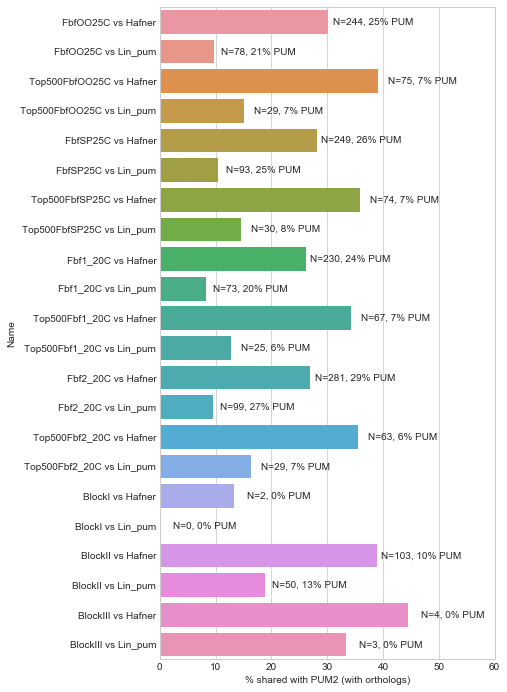

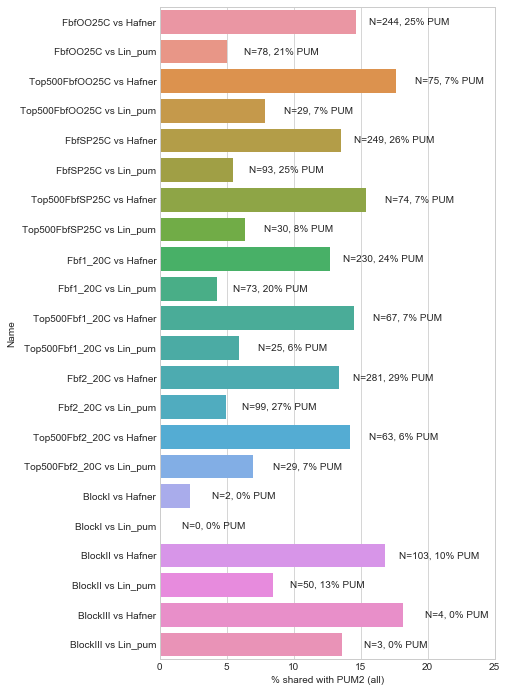

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

def refresh():
    plt.clf()
    plt.close()
    
overlaps = pandas.DataFrame(overlap_tables)
#print(overlaps)
overlaps['FBF targets'] = [a+ab for a, ab in zip(overlaps.a_target_only, overlaps.shared_targets)]
overlaps['% shared with PUM2 (all)'] = [100*ab/t for ab, t in zip(
    overlaps['FBF targets shared including homologs'], overlaps['FBF targets input'])]

overlaps['% shared with PUM2 (with orthologs)'] = [
    100*ab/t for ab, t in zip(overlaps.shared_targets, overlaps['FBF targets'])]

overlaps.index = overlaps.Name

skippy = '''
order = ['OO FBF-1 (20°C)', 'OO FBF-1 (20°C) top 500',
 'OO FBF-2 (20°C)', 'OO FBF-2 (20°C) top 500',
 'OO FBF (25°C)', 'OO FBF (25°C) top 500', 
 'SP FBF (25°C)', 'SP FBF (25°C) top 500', 
 'Common', 'Common top 500', 
        'Block I', 'Block II',
       'Block III', 'All mRNA']
overlaps = overlaps.reindex(order)'''
#print(overlaps.index)
print(overlaps.head(2))
sns.set_style("whitegrid")
refresh()
fig = plt.figure()
ax = sns.barplot(x='% shared with PUM2 (with orthologs)', y='Name', data=overlaps)
fig.set_figheight(12)
ax.set_xlim(0, 60)

overlaps['% PUM targets'] = [100* x/y for x,y in zip(
    overlaps['shared_targets'], overlaps['PUM targets translated and combined']
    #overlaps['shared_targets'] + overlaps['b_target_only'])]
    )]

for p, n, percpum, ind in zip(
    ax.patches, overlaps['shared_targets'], overlaps['% PUM targets'],
    overlaps['PUM targets in native language']):
    #print(p.get_height())
    print(p.get_width())
    print(p.get_y())
    ax.annotate("N={0}, {1}% PUM".format(n, int(percpum)),
        (p.get_x() + p.get_width() + 8, p.get_y() + (p.get_height()/2)),
         ha='center', va='center', rotation=0,
    ) 

fig.savefig('../figs/shared_with_PUM2_with_orthologs.pdf')
plt.show()
refresh()

fig = plt.figure()
fig.set_figheight(12)
ax = sns.barplot(x='% shared with PUM2 (all)', y='Name', data=overlaps)
ax.set_xlim(0, 25)
for p, n, ind in zip(ax.patches, overlaps['shared_targets'], overlaps['% PUM targets']):
    ax.annotate("N={0}, {1}% PUM".format(n, int(ind)),
        (p.get_x() + p.get_width() + 4, p.get_y() + (p.get_height()/2)),
         ha='center', va='center', rotation=0,
    ) 

fig.savefig('../figs/shared_with_PUM2.pdf')
plt.show()
refresh()

overlaps.to_excel('output/overlaps_results.xlsx')

In [156]:
pum2_ensembl_ts = pum2Helper.pum2Helper().pum2_targets_as_ensembl(orthos)

...Created a complexTargetSet (PUM2) in language Ensmbl:
{'Number of gene sets': 2580, 'Native language': 'Ensmbl', 'Name': 'PUM2', 'Examples of gene sets': [frozenset({'ENSG00000118816'}), frozenset({'ENSG00000140104'}), frozenset({'ENSG00000106617'}), frozenset({'ENSG00000160746'}), frozenset({'ENSG00000112319'}), frozenset({'ENSG00000124279'}), frozenset({'ENSG00000051108'}), frozenset({'ENSG00000197020'}), frozenset({'ENSG00000129810'}), frozenset({'ENSG00000166483'})]}
Total number of loci in ortholist: 7647. With translation to ESNGxx: 7639.
complexTranslation.qc(): All IDs are in one gene set.
Removing non-translatable genes: input 2580
...943 were translatable.


In [5]:
import simple
import simple.fbfTargets
importlib.reload(simple.fbfTargets)

fbf = simple.fbfTargets.fbfTargets()
fbf.read_fbf_targets()

print("done.")


---
Loading /Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl//tables/Table S1 Peaks.xls - OO FBF (25°C)

---
Loading /Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl//tables/Table S1 Peaks.xls - SP FBF (25°C)

---
Loading /Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl//tables/Table S1 Peaks.xls - OO FBF-1 (20°C)

---
Loading /Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl//tables/Table S1 Peaks.xls - OO FBF-2 (20°C)

---
Loading /Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl//tables/Table S6 Blocks.xls - Block I

---
Loading /Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl//tables/Table S6 Blocks.xls - Block II

---
Loading /Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl//tables/Table S6 Blocks.xls - Block III
Using Gene name...
Using Gene name...
Using Gene name...
done.


In [16]:

fbf_ensg = [
    orthos[2].translate(x) for x in fbf.target_lists_dfs['OO FBF (25°C)']['transcript_id']]
fbf_ensg = [x for x in fbf_ensg if len(x)]

pum2_ensg = pum2_ensembl_ts.cgenes_as_flattened_set()
print(list(pum2_ensg)[:10])

overlaps = set()
for target_set in fbf_ensg:
    if target_set & pum2_ensg:
        overlaps.add(list(target_set & pum2_ensg)[0])
print("{0} out of {1} fbf targets overlaped with {2} PUM2 ENSGs.".format(
    len(overlaps), len(fbf_ensg), len(pum2_ensg)))
print("% overlap = {0}".format(len(overlaps)/len(fbf_ensg)))
print('Done')

['ENSG00000143457', 'ENSG00000163029', 'ENSG00000185414', 'ENSG00000088766', 'ENSG00000204370', 'ENSG00000145860', 'ENSG00000018510', 'ENSG00000174405', 'ENSG00000111011', 'ENSG00000066777']
139 out of 595 fbf targets overlaped with 943 PUM2 ENSGs.
% overlap = 0.23361344537815126
Done


In [11]:
print(fbf.target_lists_dfs.keys())

dict_keys(['OO FBF (25°C)', 'SP FBF (25°C)', 'OO FBF-1 (20°C)', 'OO FBF-2 (20°C)', 'Block I', 'Block II', 'Block III'])
